In [1000]:
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
from tqdm import tqdm
from pickle import dump, load
from itertools import chain, combinations

# Lattice structure

In [1238]:
# Define the lattice structure
Lx = 3
Ly = 3

# Utils and operators

In [1239]:
# Create the sparse matrix
dimh = 2**(2*Lx*Ly)
dimph = 2**(Lx*Ly - 1)
hamiltonian = lil_matrix((dimh, dimh))


# Index mapping
def index2coord(index):
    assert index < 2 * Lx * Ly
    dir = index % 2
    return (index // 2) % Lx, (index // 2) // Lx, dir

def coord2index(x, y, dir):
    assert x < Lx
    assert y < Ly
    return 2 * (y * Lx + x) + dir


# States printing
def vector2basis(vector):
    assert len(vector) == dimh
    basis = []
    expr = ""
    for i in range(dimh):
        if np.abs(vector[i]) >= 10**(-5):
            v = vector[i]
            if v < 0:
                expr += " - "
                v *= -1
            else:
                expr += " + "
            if v != 1:
                expr += str(np.round(v, 2))
            expr += "|"
            for j in range(2*Lx*Ly):
                if i & (1 << j):
                    expr += "↓"
                else:
                    expr += "↑"
            expr += ">"
    return expr

In [1240]:
# Local plaquette term
def compute_plaquette(x, y):
    pl = lil_matrix((dimh, dimh))
    i0 = coord2index(x, y, 0)
    i1 = coord2index((x + 1) % Lx, y, 1)
    i2 = coord2index(x, (y + 1) % Ly, 0)
    i3 = coord2index(x, y, 1)
    diagh = [1] * dimh
    for i in range(dimh):
        if i & (1 << i0):
            diagh[i] *= -1
        if i & (1 << i1):
            diagh[i] *= -1
        if i & (1 << i2):
            diagh[i] *= -1
        if i & (1 << i3):
            diagh[i] *= -1
    for i in range(dimh):
        pl[i, i] += diagh[i]
    return pl

# Local link term
def compute_potential(x, y):
    pot = lil_matrix((dimh, dimh))
    i0 = coord2index(x, y, 0)
    i1 = coord2index((x + 1) % Lx, y, 1)
    i2 = coord2index(x, (y + 1) % Ly, 0)
    i3 = coord2index(x, y, 1)
    for i in range(dimh):
        pot[i, i ^ (1 << i0)] += 1 / 2
        pot[i, i ^ (1 << i1)] += 1 / 2
        pot[i, i ^ (1 << i2)] += 1 / 2
        pot[i, i ^ (1 << i3)] += 1 / 2
    return pot

We can compute these operators once and for all to spare time later:

In [1422]:
plaquette = []
potential = []
for x in tqdm(range(Lx)):
    plaquette.append([])
    potential.append([])
    for y in range(Ly):
        plaquette[x].append(compute_plaquette(x, y))
        potential[x].append(compute_potential(x, y))

100%|██████████| 3/3 [00:40<00:00, 13.55s/it]


We construct the two terms of the full hamiltonian separately:

In [1243]:
# Identity
identity = lil_matrix((dimh, dimh))
for i in range(dimh):
    identity[i, i] = 1

# Plaquette terms
print("Enter plaquette terms...")
plaquette_hamiltonian = lil_matrix((dimh, dimh))
for x in tqdm(range(Lx)):
    for y in range(Ly):
        i0 = coord2index(x, y, 0)
        i1 = coord2index((x + 1) % Lx, y, 1)
        i2 = coord2index(x, (y + 1) % Ly, 0)
        i3 = coord2index(x, y, 1)
        diagh = [1] * dimh
        for i in range(dimh):
            if i & (1 << i0):
                diagh[i] *= -1
            if i & (1 << i1):
                diagh[i] *= -1
            if i & (1 << i2):
                diagh[i] *= -1
            if i & (1 << i3):
                diagh[i] *= -1
        for i in range(dimh):
            plaquette_hamiltonian[i, i] += diagh[i]

# Link terms
print("Enter link terms...")
link_hamiltonian = lil_matrix((dimh, dimh))
for x in tqdm(range(Lx)):
    for y in range(Ly):
        for dir in range(2):
            i0 = coord2index(x, y, dir)
            for i in range(dimh):
                link_hamiltonian[i, i ^ (1 << i0)] += 1

Enter plaquette terms...


100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


Enter link terms...


100%|██████████| 3/3 [00:13<00:00,  4.62s/it]


In [1424]:
# Pauli matrices
def sigma_z(x, y, dir):
    i = coord2index(x, y, dir)
    s_z = lil_matrix((dimh, dimh))
    for j in range(dimh):
        if (j & (1 << i)) >> i:
            s_z[j, j] = -1
        else:
            s_z[j, j] = 1
    return s_z

def sigma_x(x, y, dir):
    i0 = coord2index(x, y, dir)
    s_x = lil_matrix((dimh, dimh))
    for i in range(dimh):
        s_x[i, i ^ (1 << i0)] += 1
    return s_x

# Local gauge transformations
def G(x, y):
    i0 = coord2index(x, y, 0)
    i1 = coord2index(x, y, 1)
    i2 = coord2index((x - 1) % Lx, y, 0)
    i3 = coord2index(x, (y - 1) % Ly, 1)
    gauge_transformation = lil_matrix((dimh, dimh))
    for i in range(dimh):
        gauge_transformation[i, i ^ (1 << i0) ^ (1 << i1) ^ (1 << i2) ^ (1 << i3)] = 1
    return gauge_transformation

# Topological gauge transformations
Vx = lil_matrix((dimh, dimh))
Vy = lil_matrix((dimh, dimh))
for x in range(Lx):
    Vx = sigma_x(x, 0, 1) @ Vx
for y in range(Ly):
    Vy = sigma_x(0, y, 0) @ Vy

# Translation operators
def T(dx, dy):
    translation = lil_matrix((dimh, dimh))
    for j in range(dimh):
        j1 = 0
        for i in range(2 * Lx * Ly):
            x, y, dir = index2coord(i)
            ji0 = (j & (1 << i)) >> i
            i1 = coord2index((x + dx) % Lx, (y + dy) % Ly, dir)
            j1 += ji0 << i1
        translation[j, j1] = 1
    return translation

In [1425]:
# Sin of the impulsion
Px = (T(1, 0) - T(-1, 0)) / (2j)
Py = (T(0, 1) - T(0, -1)) / (2j)

# Sin squared of the impulsion
Px2 = (2*identity - T(1, 0) - T(-1, 0)) / 4
Py2 = (2*identity - T(0, 1) - T(0, -1)) / 4

# Direct diagonalization

The gauge conditions are imposed by adding constraints to the hamiltonian

In [1426]:
def hamiltonian(K, g):
    return - K * plaquette_hamiltonian - g * link_hamiltonian

def energy_density(x, y, K, g):
    return - K * plaquette[x, y] - g * potential[x, y]

BIG = 1000

def penalized_hamiltonian(K, g):
    H = - hamiltonian(K, g)

    shift = 2 * (K*Lx*Ly + 2*g*Lx*Ly)
    H += shift * identity

    H += BIG * Lx * Ly * identity
    for x in tqdm(range(Lx)):
        for y in range(Ly):
            H -= BIG * (G(x, y) - identity) @ (G(x, y) - identity) / 4
    
    H += BIG * 2 * identity
    H -= BIG * (Vx- identity) @ (Vx - identity) / 4
    H -= BIG * (Vy- identity) @ (Vy - identity) / 4

    return H

In [1427]:
def direct_diagonalization(K, g, num_eigenvalues=dimph):
    H = penalized_hamiltonian(K, g)
    eigenvalues, eigenvectors = eigsh(H, k=num_eigenvalues, which='LM')
    shift = 2 * (K*Lx*Ly + 2*g*Lx*Ly)
    eigenvalues -= shift
    eigenvalues -= BIG * Lx * Ly
    eigenvalues -= BIG * 2
    eigenvalues *= -1
    return eigenvalues, eigenvectors.transpose()

# Projection in physical space

In [1428]:
def pair_excitation(vacuum, x1, y1, x2, y2):
    assert x1 < Lx
    assert y1 < Ly
    assert x2 < Lx
    assert y2 < Ly
    assert x1 != x2 or y1 != y2
    state = vacuum.copy()
    if x1 < x2:
        for x in range(x1+1, x2+1):
            state = sigma_x(x, y1, 1) @ state
    else:
        for x in range(x2+1, x1+1):
            state = sigma_x(x, y1, 1) @ state
    if y1 < y2:
        for y in range(y1+1, y2+1):
            state = sigma_x(x2, y, 0) @ state
    else:
        for y in range(y2+1, y1+1):
            state = sigma_x(x2, y, 0) @ state
    return state / np.linalg.norm(state)

# List of unordered sets of a list
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))

# Generate all the excitations of the vacuum
def generate_all_excitations(vacuum):
    physical_basis = []
    coords = [(x, y) for x in range(Lx) for y in range(Ly)]
    subsets_prior = powerset(coords)
    subsets = []
    for s in subsets_prior:
        if len(s) % 2 == 0:
            subsets.append(s)
    for subset in tqdm(subsets):
        if len(subset) % 2 == 1:
            continue
        if len(subset) == 0:
            state = vacuum.copy()
            physical_basis.append(state)
            continue
        elif len(subset) == 2:
            state = vacuum.copy()
        else:
            subsubset = subset[:-2]
            j = subsets.index(subsubset)
            state = physical_basis[j].copy()
        x1, y1 = subset[-2]
        x2, y2 = subset[-1]
        state = pair_excitation(state, x1, y1, x2, y2)
        physical_basis.append(state)
    return np.array(physical_basis)

In [1319]:
# Project on physical space
def project_physical(state):
    for x in range(Lx):
        for y in range(Ly):
            state = (identity + G(x, y)) @ state
            state /= np.linalg.norm(state)
    for order in range(1, L):
        state = (identity + Vx[order]) @ state
        state = (identity + Vy[order]) @ state
        state /= np.linalg.norm(state)
    return state

# Orthogonalize
def orthogonalize(state, states):
    for i in range(len(states)):
        state -= (states[i].transpose() @ state) * states[i]
    state /= np.linalg.norm(state)
    return state

def orthonormalize(states):
    for i in range(len(states)):
        states[i] = orthogonalize(states[i], states[:i])
    return states

# Build a random basis of the physical space
def random_physical_basis():
    physical_basis = []
    for i in tqdm(range(dimph)):
        state = np.random.rand(dimh)
        state = project_physical(state)
        state = orthogonalize(state, physical_basis)
        physical_basis.append(state)
    return np.array(physical_basis)

# Test orthogonality
def is_orthogonal(basis, epsilon=10**(-5)):
    for i in range(len(basis)):
        for j in range(i):
            if np.abs(basis[i].transpose() @ basis[j]) > epsilon:
                return False
    return True

We build the ground state of our free theory in the physical space by applying all the gauge and topological constraints

In [1259]:
# Build the ground state of the free theory
free_ground_state = np.zeros(dimh)
free_ground_state[0] = 1

for x in range(Lx):
    for y in range(Ly):
        free_ground_state = (identity + G(x, y)) @ free_ground_state / np.sqrt(2)
free_ground_state = (identity + Vx) @ free_ground_state / np.sqrt(2)
free_ground_state = (identity + Vy) @ free_ground_state / np.sqrt(2)

free_ground_state /= np.linalg.norm(free_ground_state)

print("Free ground state: ", vector2basis(free_ground_state))
print("Norm of the free ground state: ", np.linalg.norm(free_ground_state))
print("Vacuum energy: ", free_ground_state.transpose() @ hamiltonian(1, 0) @ free_ground_state)

Free ground state:   + 0.03|↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑> + 0.03|↑↓↑↓↑↓↑↑↑↑↑↑↑↑↑↑↑↑> + 0.03|↑↑↑↓↑↑↓↑↓↓↑↑↑↑↑↑↑↑> + 0.03|↑↓↑↑↑↓↓↑↓↓↑↑↑↑↑↑↑↑> + 0.03|↑↓↑↑↑↑↓↓↑↑↓↑↑↑↑↑↑↑> + 0.03|↑↑↑↓↑↓↓↓↑↑↓↑↑↑↑↑↑↑> + 0.03|↑↓↑↓↑↑↑↓↓↓↓↑↑↑↑↑↑↑> + 0.03|↑↑↑↑↑↓↑↓↓↓↓↑↑↑↑↑↑↑> + 0.03|↑↑↑↓↑↑↓↓↓↑↑↓↑↑↑↑↑↑> + 0.03|↑↓↑↑↑↓↓↓↓↑↑↓↑↑↑↑↑↑> + 0.03|↑↑↑↑↑↑↑↓↑↓↑↓↑↑↑↑↑↑> + 0.03|↑↓↑↓↑↓↑↓↑↓↑↓↑↑↑↑↑↑> + 0.03|↑↓↑↓↑↑↑↑↓↑↓↓↑↑↑↑↑↑> + 0.03|↑↑↑↑↑↓↑↑↓↑↓↓↑↑↑↑↑↑> + 0.03|↑↓↑↑↑↑↓↑↑↓↓↓↑↑↑↑↑↑> + 0.03|↑↑↑↓↑↓↓↑↑↓↓↓↑↑↑↑↑↑> + 0.03|↓↑↑↑↑↑↓↑↑↑↑↑↓↑↑↑↑↑> + 0.03|↓↓↑↓↑↓↓↑↑↑↑↑↓↑↑↑↑↑> + 0.03|↓↑↑↓↑↑↑↑↓↓↑↑↓↑↑↑↑↑> + 0.03|↓↓↑↑↑↓↑↑↓↓↑↑↓↑↑↑↑↑> + 0.03|↓↓↑↑↑↑↑↓↑↑↓↑↓↑↑↑↑↑> + 0.03|↓↑↑↓↑↓↑↓↑↑↓↑↓↑↑↑↑↑> + 0.03|↓↓↑↓↑↑↓↓↓↓↓↑↓↑↑↑↑↑> + 0.03|↓↑↑↑↑↓↓↓↓↓↓↑↓↑↑↑↑↑> + 0.03|↓↑↑↓↑↑↑↓↓↑↑↓↓↑↑↑↑↑> + 0.03|↓↓↑↑↑↓↑↓↓↑↑↓↓↑↑↑↑↑> + 0.03|↓↑↑↑↑↑↓↓↑↓↑↓↓↑↑↑↑↑> + 0.03|↓↓↑↓↑↓↓↓↑↓↑↓↓↑↑↑↑↑> + 0.03|↓↓↑↓↑↑↓↑↓↑↓↓↓↑↑↑↑↑> + 0.03|↓↑↑↑↑↓↓↑↓↑↓↓↓↑↑↑↑↑> + 0.03|↓↓↑↑↑↑↑↑↑↓↓↓↓↑↑↑↑↑> + 0.03|↓↑↑↓↑↓↑↑↑↓↓↓↓↑↑↑↑↑> + 0.03|↓↓↑↑↓↑↑↑↑↑↑↑↑↓↑↑↑↑> + 0.03|↓↑↑↓↓↓↑↑↑↑↑↑↑↓↑↑↑↑> + 0.03|↓↓↑↓↓↑↓↑↓↓↑↑↑↓↑↑↑↑> + 0.03|↓↑↑↑↓↓↓↑↓↓↑↑↑↓↑↑↑↑> + 0.03|

We can then generate the free basis by exciting the free ground state

In [1079]:
free_basis = generate_all_excitations(free_ground_state)

100%|██████████| 512/512 [15:45<00:00,  1.85s/it]


And we can project all our operators in the physical space:

In [1284]:
sigma_x_ph = []
for x in tqdm(range(Lx)):
    sigma_x_ph.append([])
    for y in range(Ly):
        sigma_x_ph[x].append([])
        for dir in range(2):
            sigma_x_ph[x][y].append(free_basis @ sigma_x(x, y, dir) @ free_basis.transpose())

sigma_z_ph = []
for x in tqdm(range(Lx)):
    sigma_z_ph.append([])
    for y in range(Ly):
        sigma_z_ph[x].append([])
        for dir in range(2):
            sigma_z_ph[x][y].append(free_basis @ sigma_z(x, y, dir) @ free_basis.transpose())

def sigma_x_physical(x, y, dir):
    return sigma_x_ph[x][y][dir]

def sigma_z_physical(x, y, dir):
    return sigma_z_ph[x][y][dir]

100%|██████████| 3/3 [00:40<00:00, 13.51s/it]


In [1292]:
def pair_excitation_physical(vacuum, x1, y1, x2, y2):
    assert x1 < Lx
    assert y1 < Ly
    assert x2 < Lx
    assert y2 < Ly
    assert x1 != x2 or y1 != y2
    state = vacuum.copy()
    if x1 < x2:
        for x in range(x1+1, x2+1):
            state = sigma_x_physical(x, y1, 1) @ state
    else:
        for x in range(x2+1, x1+1):
            state = sigma_x_physical(x, y1, 1) @ state
    if y1 < y2:
        for y in range(y1+1, y2+1):
            state = sigma_x_physical(x2, y, 0) @ state
    else:
        for y in range(y2+1, y1+1):
            state = sigma_x_physical(x2, y, 0) @ state
    return state / np.linalg.norm(state)

def generate_all_excitations_physical(vacuum):
    physical_basis = []
    coords = [(x, y) for x in range(Lx) for y in range(Ly)]
    subsets_prior = powerset(coords)
    subsets = []
    for s in subsets_prior:
        if len(s) % 2 == 0:
            subsets.append(s)
    for subset in tqdm(subsets):
        if len(subset) % 2 == 1:
            continue
        if len(subset) == 0:
            state = vacuum.copy()
            physical_basis.append(state)
            continue
        elif len(subset) == 2:
            state = vacuum.copy()
        else:
            subsubset = subset[:-2]
            j = subsets.index(subsubset)

            state = physical_basis[j].copy()
        x1, y1 = subset[-2]
        x2, y2 = subset[-1]
        state = pair_excitation_physical(state, x1, y1, x2, y2)
        physical_basis.append(state)
    return np.array(physical_basis)

Finally, we define the diagonalization in the physical space, which is much quicker:

In [1429]:
# Hamiltonian in the basis
physical_plaquette_hamiltonian = free_basis @ plaquette_hamiltonian @ free_basis.transpose()
physical_link_hamiltonian = free_basis @ link_hamiltonian @ free_basis.transpose()

In [1263]:
def physical_hamiltonian(K, g):
    return - K * physical_plaquette_hamiltonian - g * physical_link_hamiltonian

In [1264]:
def physical_diagonalization(K, g):
    eigenvalues, eigenvectors = np.linalg.eigh(physical_hamiltonian(K, g))
    return eigenvalues, eigenvectors.transpose()

Let's see the shape of the spectrum as a function of $g$:

  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 99/99 [00:01<00:00, 63.73it/s]
C:\Users\thoma\AppData\Local\Temp\ipykernel_30352\4027784329.py:17: RuntimeWarning: divide by zero encountered in divide
  ax.set_xscale('function', functions = (lambda x: -np.log(1 / x - 1) / 1, lambda x: 1 / (1 + np.exp(-0.7*x))))
C:\Users\thoma\AppData\Local\Temp\ipykernel_30352\4027784329.py:17: RuntimeWarning: divide by zero encountered in log
  ax.set_xscale('function', functions = (lambda x: -np.log(1 / x - 1) / 1, lambda x: 1 / (1 + np.exp(-0.7*x))))
C:\Users\thoma\AppData\Local\Temp\ipykernel_30352\4027784329.py:17: RuntimeWarning: divide by zero encountered in divide
  ax.set_xscale('function', functions = (lambda x: -np.log(1 / x - 1) / 1, lambda x: 1 / (1 + np.exp(-0.7*x))))
C:\Users\thoma\AppData\Local\Temp\ipykernel_30352\4027784329.py:17: RuntimeWarning: divide by zero encountered in log
  ax.set_xscale('function', functions = (lambda x: -np.log(1 / x - 1) / 1, lambda x: 1 / (1 + np.exp(-0.7*x))))


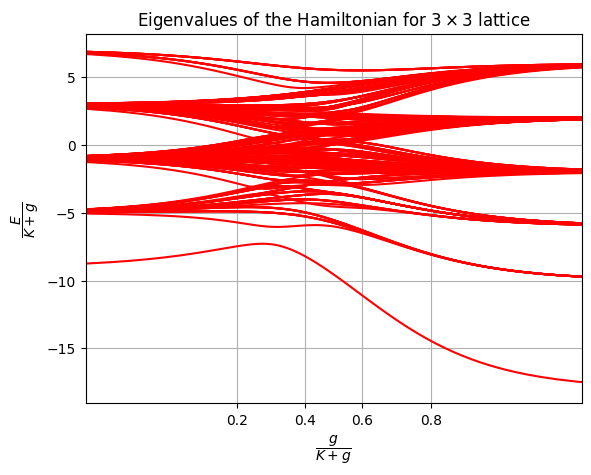

In [1431]:
fig, ax = plt.subplots()

Eigenvalues = []
Gs = []

for i in tqdm(range(1, 100)):
    eigenvalues, eigenvectors = physical_diagonalization(1 - 0.01*i, 0.01*i)
    Gs.append(0.01*i)
    Eigenvalues.append(eigenvalues)

Eigenvalues = np.array(Eigenvalues)

for i in range(dimph):
    ax.plot(Gs, Eigenvalues[:, i], "r")

ax.set_title("Eigenvalues of the Hamiltonian for $3\\times 3$ lattice")
ax.set_xscale('function', functions = (lambda x: -np.log(1 / x - 1) / 1, lambda x: 1 / (1 + np.exp(-0.7*x))))
ax.grid(True)
plt.xlabel("$\dfrac{g}{K+g}$")
plt.ylabel("$\dfrac{E}{K+g}$")

plt.savefig("eigenvalues3_sigmoid.pdf")
plt.show()

# Time evolution in $3\times3$ lattice

In [1217]:
def evolution(state, t, eigenvectors, eigenvalues):
    state_t = eigenvectors @ state
    state_t = np.exp(-1j * (eigenvalues - eigenvalues[0]) * t) * state_t
    state_t = eigenvectors.transpose() @ state_t
    return state_t / np.linalg.norm(state_t)

First, in order to get an idea of the physical behaviour of the system, we can look at the probabilities of finding different number of visions in the vacuum state of our interacting theory, as a function of the interaction strength $g$:

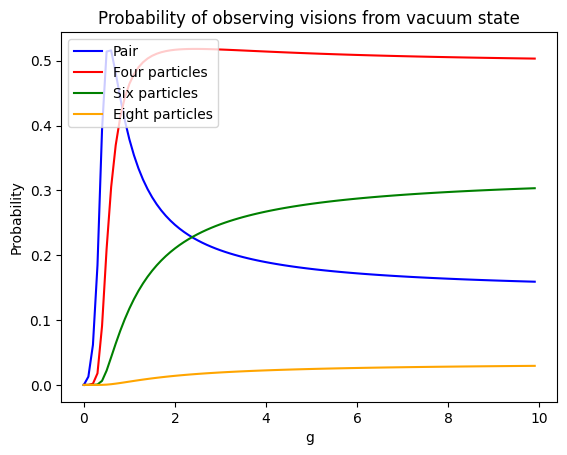

In [1430]:
probs2 = []
probs4 = []
probs6 = []
probs8 = []
Gs = []

for i in range(100):
    g = 0.1 * i
    K = 1
    Gs.append(g)

    eigenvalues, eigenvectors = physical_diagonalization(K, g)
    basis = np.identity(dimph)

    pair_states = basis[1:1 + 36]
    four_states = basis[1 + 36:1 + 36 + 126]
    six_states = basis[1 + 36 + 126:1 + 36 + 126 + 84]
    eight_states = basis[1 + 36 + 126 + 84:1 + 36 + 126 + 84 + 9]

    probs2.append(np.sum(np.abs((eigenvectors[0].transpose().conj() @ pair_states.transpose()))**2))
    probs4.append(np.sum(np.abs((eigenvectors[0].transpose().conj() @ four_states.transpose()))**2))
    probs6.append(np.sum(np.abs((eigenvectors[0].transpose().conj() @ six_states.transpose()))**2))
    probs8.append(np.sum(np.abs((eigenvectors[0].transpose().conj() @ eight_states.transpose()))**2))

plt.plot(Gs, probs2, label="Pair", color="blue")
plt.plot(Gs, probs4, label="Four particles", color="red")
plt.plot(Gs, probs6, label="Six particles", color="green")
plt.plot(Gs, probs8, label="Eight particles", color="orange")

plt.legend()
plt.title("Probability of observing visions from vacuum state")
plt.xlabel("g")
plt.ylabel("Probability")
plt.savefig("vision_production.pdf")
plt.show()

Then, we can look at the evolution of the probabilities associated to each number of visions with time, with an initial state containing no visions:

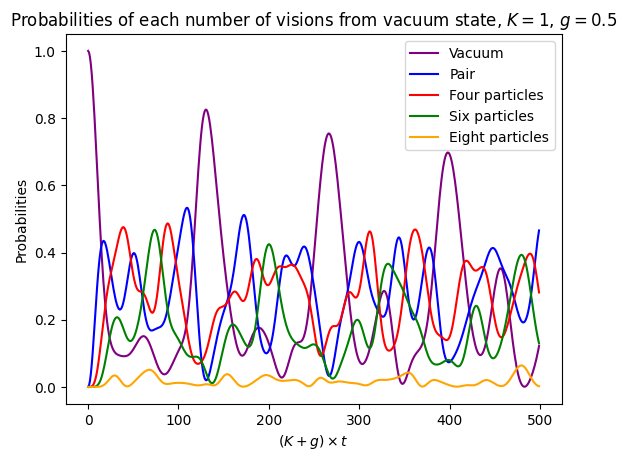

In [1432]:
g = 1

K = 1 / (1+g)
g = g / (1+g)

eigenvalues, eigenvectors = physical_diagonalization(K, g)

basis = np.identity(dimph)
initial_state = basis[0]

pair_states = basis[1:1 + 36]
four_states = basis[1 + 36:1 + 36 + 126]
six_states = basis[1 + 36 + 126:1 + 36 + 126 + 84]
eight_states = basis[1 + 36 + 126 + 84:1 + 36 + 126 + 84 + 9]

prob_vacuum = []
prob_pair = []
prob_four = []
prob_six = []
prob_eight = []
number = []
energy = []

for i in range(500):
    state = evolution(initial_state, - i * 0.01 * np.pi, eigenvectors, eigenvalues)

    energy.append(state.transpose().conj() @ physical_hamiltonian(K, g) @ state)

    p0 = np.abs(state.transpose().conj() @ basis[0])**2
    p2 = np.sum(np.abs((state.transpose().conj() @ pair_states.transpose()))**2)
    p4 = np.sum(np.abs((state.transpose().conj() @ four_states.transpose()))**2)
    p6 = np.sum(np.abs((state.transpose().conj() @ six_states.transpose()))**2)
    p8 = np.sum(np.abs((state.transpose().conj() @ eight_states.transpose()))**2)

    prob_vacuum.append(p0)
    prob_pair.append(p2)
    prob_four.append(p4)
    prob_six.append(p6)
    prob_eight.append(p8)

    number.append(2*p2 + 4*p4 + 6*p6 + 8*p8)

plt.plot(prob_vacuum, label="Vacuum", color="purple")
plt.plot(prob_pair, label="Pair", color="blue")
plt.plot(prob_four, label="Four particles", color="red")
plt.plot(prob_six, label="Six particles", color="green")
plt.plot(prob_eight, label="Eight particles", color="orange")

plt.legend()
plt.title("Probabilities of each number of visions from vacuum state, $g=" + str(np.round(g, 1)) + "$")
plt.xlabel("$(1+g)\\times t$")
plt.ylabel("Probabilities")
plt.legend()
plt.show()

We can now look at the evolution of the average number of visions from an initial state with no visions, for different values of $g$:

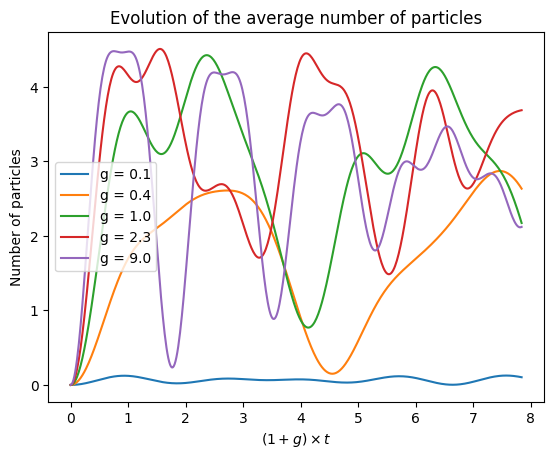

In [1417]:
for j in range(5):
    g = 0.2*(j+0.5)
    K = 1 - g

    eigenvalues, eigenvectors = physical_diagonalization(K, g)

    basis = np.identity(len(basis))
    initial_state = basis[0]

    pair_states = basis[1:1 + 36]
    four_states = basis[1 + 36:1 + 36 + 126]
    six_states = basis[1 + 36 + 126:1 + 36 + 126 + 84]
    eight_states = basis[1 + 36 + 126 + 84:1 + 36 + 126 + 84 + 9]

    number = []
    T = []
    for i in range(500):
        state = evolution(initial_state, - i * 0.005 * np.pi, eigenvectors, eigenvalues)
        T.append(i * 0.005 * np.pi)

        p0 = np.abs(state.transpose().conj() @ basis[0])**2
        p2 = np.sum(np.abs((state.transpose().conj() @ pair_states.transpose()))**2)
        p4 = np.sum(np.abs((state.transpose().conj() @ four_states.transpose()))**2)
        p6 = np.sum(np.abs((state.transpose().conj() @ six_states.transpose()))**2)
        p8 = np.sum(np.abs((state.transpose().conj() @ eight_states.transpose()))**2)
        
        number.append(2*p2 + 4*p4 + 6*p6 + 8*p8)

    plt.plot(T, number, label="g = " + str(np.round(g / K, 1)))

plt.title("Evolution of the average number of particles")
plt.xlabel("$(1+g)\\times t$")
plt.ylabel("Number of particles")
plt.legend()
plt.savefig("number.pdf")
plt.show()